# YouTube Comment Cleaning and Exploration

Takes data from a CSV file and cleans the data to isolate comments of interest

In [1]:
import re
import japanize_matplotlib
import matplotlib.pyplot as plt
import nagisa
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from functools import reduce
from operator import add
from pathlib import Path

NumExpr defaulting to 8 threads.


In [2]:
input_path = Path('Resources/youtube_comments.csv')
comments_df = pd.read_csv(input_path, index_col=0)

comments_df.head(10)

channel     video_id  category_id  \
0  mwamjapan  Jb6Zlg30rgk           10   
1  mwamjapan  Jb6Zlg30rgk           10   
2  mwamjapan  Jb6Zlg30rgk           10   
3  mwamjapan  Jb6Zlg30rgk           10   
4  mwamjapan  Jb6Zlg30rgk           10   
5  mwamjapan  Jb6Zlg30rgk           10   
6  mwamjapan  Jb6Zlg30rgk           10   
7  mwamjapan  Jb6Zlg30rgk           10   
8  mwamjapan  Jb6Zlg30rgk           10   
9  mwamjapan  Jb6Zlg30rgk           10   

                                                text        date_published  \
0        This season is going to be a masterpiece <3  2023-04-16T15:39:10Z   
1                    Every season is masterpiece üî•üî•üî•  2023-04-17T16:41:52Z   
2                                   @HM cry about it  2023-04-17T16:15:19Z   
3  @HM dude demon slayer has no story but it has ...  2023-04-17T15:44:29Z   
4                                          @HM üôÇüôÉüòíüòíüòí  2023-04-17T13:44:05Z   
5  Honestamente no entiendo porqu√© esta canci√≥n r...  2023-04-17T03:58:25Z   
6                           ‚Äã@„Åø„Å£„Åè„ÇììàíìÇÇ‚óåùôºùô∏ùöàùöÑ llora pues  2023-04-17T17:15:35Z   
7                          „Åü„Åã„ÅåOP„Åß‰∏ñÁïåË¶≥„ÅåÂ£ä„Çå„Çã„Ç¢„Éã„É°„Åò„ÇÉ„Å™„ÅÑ„Çè„ÅØ„Åí„Åü„Åì  2023-04-17T16:00:09Z   
8                                            ÊÇ©„ÇÅ„Å∞„ÄÅ„Ç§„Ç§ÔºÅ  2023-04-17T14:53:19Z   
9                          @„Åø„Å£„Åè„ÇììàíìÇÇ‚óåùôºùô∏ùöàùöÑ „Éã„ÉØ„Ç´„Åª„Å©„Åù„ÅÜË®Ä„ÅÜ„Çà„Å≠ÔºÅ  2023-04-17T13:11:13Z   

  comment_type  
0    top-level  
1        reply  
2        reply  
3        reply  
4        reply  
5    top-level  
6        reply  
7        reply  
8        reply  
9        reply

In [3]:
# RE patterns needed for JP text
hiragana = r'\u3041-\u3096'
katakana = r'\u30A1-\u30F6'
kanji = r'\u3006\u4E00-\u9FFF'

# Matches to test for existence of text that uses a Japanese script
jp_text = rf'[{hiragana}{katakana}{kanji}]'

# Accepted characters
accepted_char = rf'[a-zA-Z0-9\u30FC\u3005{hiragana}{katakana}{kanji}]'

In [4]:
# Remove @username from replies
# Done before rest of cleaning to ensure a user using a Japanese script doesn't pass filter
comments_df['text'] = comments_df['text'].str.replace(r'@\S+\s', '', regex=True)

In [5]:
# Filter out comments that don't have any Japanese characters
has_jp_char = comments_df.loc[comments_df['text'].str.contains(jp_text, regex=True)]

has_jp_char.sample(10)

channel     video_id  category_id  \
16             „Éô„Éº„Ç≥„É≥ÂÆ∂„ÅÆ„Éù„ÉÜ„Å®„Å≤„Å†„Çä  1FK4rh7iOWs           15   
97   „Éó„É¨„ÉÅ„É£„É≥ „Äê„Éó„É¨„Éü„Ç¢„É™„Éº„Ç∞ÊÉÖÂ†±„ÉÅ„É£„É≥„Éç„É´„Äë  j9gZfR3j6cU           17   
127          „ÄêRepezen Foxx„Äë  T66f7NlxdTQ           23   
34             „Éô„Éº„Ç≥„É≥ÂÆ∂„ÅÆ„Éù„ÉÜ„Å®„Å≤„Å†„Çä  1FK4rh7iOWs           15   
141           KADOKAWAanime  ThmEKGQC_s8            1   
79                 Snow Man  5-iJl-fKHwI           10   
46           ÊúâÂêâ„ÅÆÂ£Å„ÄêÂÖ¨Âºè„ÄëÂ£Å„ÉÅ„É£„É≥„Éç„É´  xQTd08X7cjY           23   
85                „Éà„É¨„Éê„Éº„Éª„Éê„Ç¶„Ç¢„Éº  9tazyKRmaZw           17   
116            „Åç„Åæ„Åê„Çå„ÇØ„ÉÉ„ÇØ„ÅÆ„Çµ„Éú„ÇäÂ†¥  HDIaYU5WaMQ           26   
56                     Â°öÂéüËæ≤Âúí  zC3D7OAlm84           26   

                                                  text        date_published  \
16   „ÉÅ„É£„Éº„Åè„Çì„ÅÆÂàù„ÇÅ„Å¶„ÅÆ„ÅäÊï£Ê≠©„ÅØ„Éë„Éë„Åï„Çì‚ú®„Éû„Éû„Åï„Çì„ÅÆ„Éâ„Ç≠„Éâ„Ç≠„Å®„ÉÅ„É£„Éº„Åè„Çì„ÇÇ„Å©„Ç≠„Éâ„Ç≠„Éâ„Å†„Å§„Åü„Å≠üê∂„Éù...  2023-04-12T20:58:03Z   
97   „Ç¶„É≥„Éë„É´„É≥„Éë„ÅØËá™ÂàÜ„ÅåË™πË¨ó‰∏≠ÂÇ∑„Åï„Çå„Åü„ÇâÊ£ö„Å´‰∏ä„Åí„Çã„ÅÆ„Å´Ëá™ÂàÜ„ÅØ„É™„Çº„É†„Å®‰∏ÄÁ∑í„Å´„Å™„Å£„Å¶‰∫∫„ÅÑ„Åò„ÇÅ„Å¶‰∏≠ÂÇ∑„Åô...  2023-04-13T12:51:06Z   
127      ËÅû„ÅÑ„Åü„ÅÆÂàù„ÇÅ„Å¶„Åò„ÇÉ„Å™„ÅÑ„Åë„Å©\n„É™„Éü„ÉÉ„ÇØ„Çπ„Å´„Å™„Å£„Å¶\nMVÈ≥•ËÇå„Åü„Å£„ÅüüòÆüéâüéâ\n„Åã„Å£„Åì„ÅÑ„ÅÑ‚ù§‚ù§  2023-04-16T11:56:53Z   
34   „Åö„Å£„Å®Ê∂ô„Åó„Å™„Åå„ÇâË¶ã„Å¶„Åæ„Åó„Åü\n„Éù„ÉÉ„Å°„ÇÉ„Çì„Å≤„Å†„Å°„ÇÉ„Çì\n„Åù„Åó„Å¶„Éë„Éë„Åï„Çì„Éû„Éû„Åï„Çì„ÅÆ\nÊÑõÊÉÖ„Åü„Å£„Å∑...  2023-04-13T07:15:44Z   
141                                     „Åì„ÅÆ5‰∫∫„ÅåÊèÉ„ÅÜ„ÅÆ„ÅØÁÜ±„Åô„Åé„ÇãÔºÅ  2023-04-15T12:12:54Z   
79                   ÊúÄÂæå„Å´„Äå„ÅÇ„ÅÑ„Åì„Å®„Å∞„Äç„Å®„ÅÑ„ÅÜÊ≠åË©û„ÇíÂ±ä„Åë„Çã„ÅÆ„ÅåÂ≤©Êú¨„Åè„Çì„Å™„ÅÆ„Éû„Ç∏„ÅßÊ≥£„Åë„Çã  2023-04-17T09:43:47Z   
46                    Â§ßÊ∞¥„Åï„ÇìÂá∫„Å¶„Åç„Åü„Å†„Åë„Åß„ÇÇÁ¨ë„Å£„Å°„ÇÉ„ÅÜ„Åã„ÇâÊúâÂêâ„ÅÆÂ£Å„ÅßË¶ã„Çå„Çã„ÅÆÊ•Ω„Åó„Åø„Å†  2023-04-13T10:04:39Z   
85   „Éû„Ç∏„Åß1„Åã„Çâ10„Åæ„Åß„Éó„É¨„Éº„ÇíÁêÜË´ñÂåñ„Åó„Å¶„ÄÅ„Åù„Çå„ÇíÂü∫„Å´„Éà„É¨„Éº„Éã„É≥„Ç∞„ÇÑË™øÊï¥„Åó„Å¶„Çã„ÅÆÂáÑ„Åô„Åé„ÇãÔºÅËá™ÂàÜ„ÅÆ...  2023-04-17T01:39:27Z   
116  ÊµúËæ∫„Éü„Éä„Éü„Å°„ÇÉ„Çì„ÅÆÊµÅ„ÄÅÂá∫„Éè‚úñÔ∏èÈ≥•Ë¶ã„Åü„ÅÑ„Å£„Å¶„Åì„Å®„ÅâÔºüÔºüÔºü\n‰∏≠ÔæÄÔæûÂ∏Ç„ÅåÊ≠¢„Åæ„Çâ„Å™„ÅÑ„ÅÉ„ÅÉ„ÅÉ„ÅÉ„ÅÉÔºÅÔºÅ...  2023-04-14T11:37:51Z   
56   „Éï„É©„Ç¨„Éº„É´„ÅØÁîò„Åï„ÅåËâØ„ÅèÂàÜ„Åã„ÇãÂìÅÁ®Æ„Åß‰∫∫Ê∞ó„Åå„ÅÇ„Çä„Åæ„Åô„Å≠„ÄÇÁöÆ„ÅÆÊüî„Çâ„Åã„Åï„Åß„ÅØ„Éó„ÉÅ„Å∑„Çà„ÄÅÁ≥ñÂ∫¶„Åß„ÅØ„Ç™„É©„É≥...  2023-04-12T14:16:09Z   

    comment_type  
16     top-level  
97         reply  
127    top-level  
34     top-level  
141    top-level  
79     top-level  
46     top-level  
85     top-level  
116        reply  
56         reply

In [6]:
# Remove other unnecessary characters - 
def clean_text(text):
    
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\t', '', text)
    text = re.sub(r'\r', '', text)
    text = re.sub(r'https?://[a-zA-Z0-9.-]*[/?[a-zA-Z0-9.-_]*]*', '', text)
    text = re.sub(r'Á¨ë+', 'Á¨ë', text)
    
    filtered_text = ''
    
    for char in text:
        if re.match(accepted_char, char):
            
            filtered_text += char
            
    return filtered_text

In [7]:
# Clean
cleaned_df = has_jp_char.copy()
cleaned_df['text'] = cleaned_df['text'].apply(clean_text)

cleaned_df.head(10)

channel     video_id  category_id  \
7   mwamjapan  Jb6Zlg30rgk           10   
8   mwamjapan  Jb6Zlg30rgk           10   
9   mwamjapan  Jb6Zlg30rgk           10   
18  mwamjapan  Jb6Zlg30rgk           10   
19  mwamjapan  Jb6Zlg30rgk           10   
44  mwamjapan  Jb6Zlg30rgk           10   
45  mwamjapan  Jb6Zlg30rgk           10   
46  mwamjapan  Jb6Zlg30rgk           10   
47  mwamjapan  Jb6Zlg30rgk           10   
48  mwamjapan  Jb6Zlg30rgk           10   

                                                 text        date_published  \
7                           „Åü„Åã„ÅåOP„Åß‰∏ñÁïåË¶≥„ÅåÂ£ä„Çå„Çã„Ç¢„Éã„É°„Åò„ÇÉ„Å™„ÅÑ„Çè„ÅØ„Åí„Åü„Åì  2023-04-17T16:00:09Z   
8                                               ÊÇ©„ÇÅ„Å∞„Ç§„Ç§  2023-04-17T14:53:19Z   
9                                         „Éã„ÉØ„Ç´„Åª„Å©„Åù„ÅÜË®Ä„ÅÜ„Çà„Å≠  2023-04-17T13:11:13Z   
18                               Áèç„Åó„Åè„Ç∑„Éß„Éº„ÉàÂãïÁîª„ÅåÂá∫„Å¶„Åæ„Åô„Å≠ÊúÄÈ´ò„Åô„Åé„Çã  2023-04-17T10:49:06Z   
19                                             „ÇÅ„Å£„Å°„ÇÉÂêåÊÑè  2023-04-17T08:30:39Z   
44  milet„Å®„ÅÆ„Ç≥„É©„Éú„Å´„ÅØÊúÄÂàù„Å≥„Å£„Åè„Çä„Åó„Åü„Åë„Å©Â£∞„ÅÆÁõ∏ÊÄß„ÅåËâØ„Åè„Å¶Áâπ„Å´Èáç„Å™„Å£„ÅüÊôÇ„Å´‰Ωï„Å®„ÇÇË®Ä„Åà„Å™„ÅÑ‰∏ç...  2023-04-17T00:54:46Z   
45  ÂÖ®„Åè‰ª∞„Çã„Å®„Åä„Çä„Åß‰Ωú‰∏≠„Å´„ÅØ„ÅÑ„Çç„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Çà„Å≠Áâπ„Å´ÂàÄÈçõÂÜ∂„ÅÆÈáåÁ∑®„ÅÆ„É©„Çπ„Éà„ÅØÁµÜ„ÉéÂ•áË∑°„Åù„ÅÆ...  2023-04-17T13:48:13Z   
46  Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇÁπã„ÅÑ„Åß„ÅÑ„Åì„ÅÜËá™ÂàÜ„ÅåÂøóÂçä„Å∞„ÅßÊ≠ª„Çì„Åß„ÇÇÁπã„ÅÑ„Å†ÂëΩ„Åå„Åç„Å£„Å®Êûú„Åü„Åó„Å¶„Åè„Çå„Çã„Å®‰∫åË©±„ÅßÁÇ≠...  2023-04-17T13:37:24Z   
47                            Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇ„Å´„ÅØÁÑ°‰∏ÄÈÉé„ÇíÊÄù„ÅÑÊµÆ„Åã„Åπ„Åæ„Åó„Åü  2023-04-17T13:07:22Z   
48                                È¨ºÊªÖ„ÅÆÂàÉ„Å´„ÅØËâ≤„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Å≠  2023-04-17T11:53:14Z   

   comment_type  
7         reply  
8         reply  
9         reply  
18        reply  
19        reply  
44    top-level  
45        reply  
46        reply  
47        reply  
48        reply

In [8]:
# Check size of DF
cleaned_df.shape

(11297, 6)

In [9]:
# Check for null values
cleaned_df.isna().sum()

channel           0
video_id          0
category_id       0
text              0
date_published    0
comment_type      0
dtype: int64

In [10]:
# Check unique values in each
cleaned_df.nunique()

channel              82
video_id             92
category_id          12
text              10659
date_published    11104
comment_type          2
dtype: int64

In [11]:
# Check amounts of top-level vs. replies for comments
cleaned_df['comment_type'].value_counts()

top-level    8320
reply        2977
Name: comment_type, dtype: int64

In [12]:
# Tokenize text
analysis_df = cleaned_df.copy()
analysis_df['tokens'] = analysis_df['text'].apply(lambda x: nagisa.tagging(x))

analysis_df.head(10)

channel     video_id  category_id  \
7   mwamjapan  Jb6Zlg30rgk           10   
8   mwamjapan  Jb6Zlg30rgk           10   
9   mwamjapan  Jb6Zlg30rgk           10   
18  mwamjapan  Jb6Zlg30rgk           10   
19  mwamjapan  Jb6Zlg30rgk           10   
44  mwamjapan  Jb6Zlg30rgk           10   
45  mwamjapan  Jb6Zlg30rgk           10   
46  mwamjapan  Jb6Zlg30rgk           10   
47  mwamjapan  Jb6Zlg30rgk           10   
48  mwamjapan  Jb6Zlg30rgk           10   

                                                 text        date_published  \
7                           „Åü„Åã„ÅåOP„Åß‰∏ñÁïåË¶≥„ÅåÂ£ä„Çå„Çã„Ç¢„Éã„É°„Åò„ÇÉ„Å™„ÅÑ„Çè„ÅØ„Åí„Åü„Åì  2023-04-17T16:00:09Z   
8                                               ÊÇ©„ÇÅ„Å∞„Ç§„Ç§  2023-04-17T14:53:19Z   
9                                         „Éã„ÉØ„Ç´„Åª„Å©„Åù„ÅÜË®Ä„ÅÜ„Çà„Å≠  2023-04-17T13:11:13Z   
18                               Áèç„Åó„Åè„Ç∑„Éß„Éº„ÉàÂãïÁîª„ÅåÂá∫„Å¶„Åæ„Åô„Å≠ÊúÄÈ´ò„Åô„Åé„Çã  2023-04-17T10:49:06Z   
19                                             „ÇÅ„Å£„Å°„ÇÉÂêåÊÑè  2023-04-17T08:30:39Z   
44  milet„Å®„ÅÆ„Ç≥„É©„Éú„Å´„ÅØÊúÄÂàù„Å≥„Å£„Åè„Çä„Åó„Åü„Åë„Å©Â£∞„ÅÆÁõ∏ÊÄß„ÅåËâØ„Åè„Å¶Áâπ„Å´Èáç„Å™„Å£„ÅüÊôÇ„Å´‰Ωï„Å®„ÇÇË®Ä„Åà„Å™„ÅÑ‰∏ç...  2023-04-17T00:54:46Z   
45  ÂÖ®„Åè‰ª∞„Çã„Å®„Åä„Çä„Åß‰Ωú‰∏≠„Å´„ÅØ„ÅÑ„Çç„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Çà„Å≠Áâπ„Å´ÂàÄÈçõÂÜ∂„ÅÆÈáåÁ∑®„ÅÆ„É©„Çπ„Éà„ÅØÁµÜ„ÉéÂ•áË∑°„Åù„ÅÆ...  2023-04-17T13:48:13Z   
46  Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇÁπã„ÅÑ„Åß„ÅÑ„Åì„ÅÜËá™ÂàÜ„ÅåÂøóÂçä„Å∞„ÅßÊ≠ª„Çì„Åß„ÇÇÁπã„ÅÑ„Å†ÂëΩ„Åå„Åç„Å£„Å®Êûú„Åü„Åó„Å¶„Åè„Çå„Çã„Å®‰∫åË©±„ÅßÁÇ≠...  2023-04-17T13:37:24Z   
47                            Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇ„Å´„ÅØÁÑ°‰∏ÄÈÉé„ÇíÊÄù„ÅÑÊµÆ„Åã„Åπ„Åæ„Åó„Åü  2023-04-17T13:07:22Z   
48                                È¨ºÊªÖ„ÅÆÂàÉ„Å´„ÅØËâ≤„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Å≠  2023-04-17T11:53:14Z   

   comment_type                                             tokens  
7         reply  „Åü„Åã/ÂêçË©û „Åå/Âä©Ë©û OP/ÂêçË©û „Åß/Âä©Ë©û ‰∏ñÁïå/ÂêçË©û Ë¶≥/Êé•Â∞æËæû „Åå/Âä©Ë©û Â£ä„Çå„Çã/ÂãïË©û ...  
8         reply                                  ÊÇ©„ÇÅ/ÂãïË©û „Å∞/Âä©Ë©û „Ç§„Ç§/ÂΩ¢ÂÆπË©û  
9         reply                „Éã„ÉØ„Ç´/ÂΩ¢Áä∂Ë©û „Åª„Å©/Âä©Ë©û „Åù„ÅÜ/ÂâØË©û Ë®Ä„ÅÜ/ÂãïË©û „Çà/Âä©Ë©û „Å≠/Âä©Ë©û  
18        reply  Áèç„Åó„Åè/ÂΩ¢ÂÆπË©û „Ç∑„Éß„Éº„Éà/ÂêçË©û ÂãïÁîª/ÂêçË©û „Åå/Âä©Ë©û Âá∫/ÂãïË©û „Å¶/Âä©ÂãïË©û „Åæ„Åô/Âä©ÂãïË©û „Å≠...  
19        reply                                      „ÇÅ„Å£„Å°„ÇÉ/ÂâØË©û ÂêåÊÑè/ÂêçË©û  
44    top-level  milet/ÂêçË©û „Å®/Âä©Ë©û „ÅÆ/Âä©Ë©û „Ç≥„É©„Éú/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û ÊúÄÂàù/ÂêçË©û „Å≥„Å£„Åè„Çä...  
45        reply  ÂÖ®„Åè/ÂâØË©û ‰ª∞„Çã/ÂãïË©û „Å®„Åä„Çä/ÂêçË©û „Åß/Âä©Ë©û ‰Ωú‰∏≠/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û „ÅÑ„Çç„Çì„Å™/ÈÄ£...  
46        reply  Êàë„Åå/ÈÄ£‰ΩìË©û ÂëΩ/ÂêçË©û Êûú„Å¶„Çà„ÅÜ/ÂãïË©û „Å®/Âä©Ë©û „ÇÇ/Âä©Ë©û Áπã„ÅÑ/ÂãïË©û „Åß/Âä©Ë©û „ÅÑ„Åì„ÅÜ/Âãï...  
47        reply  Êàë„Åå/ÈÄ£‰ΩìË©û ÂëΩ/ÂêçË©û Êûú„Å¶„Çà„ÅÜ/ÂãïË©û „Å®„ÇÇ/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û ÁÑ°‰∏ÄÈÉé/ÂêçË©û „Çí/Âä©...  
48        reply  È¨ºÊªÖ/ÂêçË©û „ÅÆ/Âä©Ë©û ÂàÉ/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û Ëâ≤„Çì„Å™/ÈÄ£‰ΩìË©û ÁµÜ„Éé/ÂêçË©û Â•áË∑°/ÂêçË©û ...

In [13]:
# Created filtered column
analysis_df['filtered_tokens'] = (analysis_df['text']
                                  .apply(lambda x: nagisa.filter(x, filter_postags=['Âä©Ë©û', 'Âä©ÂãïË©û'])))

analysis_df.head(10)

channel     video_id  category_id  \
7   mwamjapan  Jb6Zlg30rgk           10   
8   mwamjapan  Jb6Zlg30rgk           10   
9   mwamjapan  Jb6Zlg30rgk           10   
18  mwamjapan  Jb6Zlg30rgk           10   
19  mwamjapan  Jb6Zlg30rgk           10   
44  mwamjapan  Jb6Zlg30rgk           10   
45  mwamjapan  Jb6Zlg30rgk           10   
46  mwamjapan  Jb6Zlg30rgk           10   
47  mwamjapan  Jb6Zlg30rgk           10   
48  mwamjapan  Jb6Zlg30rgk           10   

                                                 text        date_published  \
7                           „Åü„Åã„ÅåOP„Åß‰∏ñÁïåË¶≥„ÅåÂ£ä„Çå„Çã„Ç¢„Éã„É°„Åò„ÇÉ„Å™„ÅÑ„Çè„ÅØ„Åí„Åü„Åì  2023-04-17T16:00:09Z   
8                                               ÊÇ©„ÇÅ„Å∞„Ç§„Ç§  2023-04-17T14:53:19Z   
9                                         „Éã„ÉØ„Ç´„Åª„Å©„Åù„ÅÜË®Ä„ÅÜ„Çà„Å≠  2023-04-17T13:11:13Z   
18                               Áèç„Åó„Åè„Ç∑„Éß„Éº„ÉàÂãïÁîª„ÅåÂá∫„Å¶„Åæ„Åô„Å≠ÊúÄÈ´ò„Åô„Åé„Çã  2023-04-17T10:49:06Z   
19                                             „ÇÅ„Å£„Å°„ÇÉÂêåÊÑè  2023-04-17T08:30:39Z   
44  milet„Å®„ÅÆ„Ç≥„É©„Éú„Å´„ÅØÊúÄÂàù„Å≥„Å£„Åè„Çä„Åó„Åü„Åë„Å©Â£∞„ÅÆÁõ∏ÊÄß„ÅåËâØ„Åè„Å¶Áâπ„Å´Èáç„Å™„Å£„ÅüÊôÇ„Å´‰Ωï„Å®„ÇÇË®Ä„Åà„Å™„ÅÑ‰∏ç...  2023-04-17T00:54:46Z   
45  ÂÖ®„Åè‰ª∞„Çã„Å®„Åä„Çä„Åß‰Ωú‰∏≠„Å´„ÅØ„ÅÑ„Çç„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Çà„Å≠Áâπ„Å´ÂàÄÈçõÂÜ∂„ÅÆÈáåÁ∑®„ÅÆ„É©„Çπ„Éà„ÅØÁµÜ„ÉéÂ•áË∑°„Åù„ÅÆ...  2023-04-17T13:48:13Z   
46  Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇÁπã„ÅÑ„Åß„ÅÑ„Åì„ÅÜËá™ÂàÜ„ÅåÂøóÂçä„Å∞„ÅßÊ≠ª„Çì„Åß„ÇÇÁπã„ÅÑ„Å†ÂëΩ„Åå„Åç„Å£„Å®Êûú„Åü„Åó„Å¶„Åè„Çå„Çã„Å®‰∫åË©±„ÅßÁÇ≠...  2023-04-17T13:37:24Z   
47                            Êàë„ÅåÂëΩÊûú„Å¶„Çà„ÅÜ„Å®„ÇÇ„Å´„ÅØÁÑ°‰∏ÄÈÉé„ÇíÊÄù„ÅÑÊµÆ„Åã„Åπ„Åæ„Åó„Åü  2023-04-17T13:07:22Z   
48                                È¨ºÊªÖ„ÅÆÂàÉ„Å´„ÅØËâ≤„Çì„Å™ÁµÜ„ÉéÂ•áË∑°„Åå„ÅÇ„Çä„Åæ„Åô„Å≠  2023-04-17T11:53:14Z   

   comment_type                                             tokens  \
7         reply  „Åü„Åã/ÂêçË©û „Åå/Âä©Ë©û OP/ÂêçË©û „Åß/Âä©Ë©û ‰∏ñÁïå/ÂêçË©û Ë¶≥/Êé•Â∞æËæû „Åå/Âä©Ë©û Â£ä„Çå„Çã/ÂãïË©û ...   
8         reply                                  ÊÇ©„ÇÅ/ÂãïË©û „Å∞/Âä©Ë©û „Ç§„Ç§/ÂΩ¢ÂÆπË©û   
9         reply                „Éã„ÉØ„Ç´/ÂΩ¢Áä∂Ë©û „Åª„Å©/Âä©Ë©û „Åù„ÅÜ/ÂâØË©û Ë®Ä„ÅÜ/ÂãïË©û „Çà/Âä©Ë©û „Å≠/Âä©Ë©û   
18        reply  Áèç„Åó„Åè/ÂΩ¢ÂÆπË©û „Ç∑„Éß„Éº„Éà/ÂêçË©û ÂãïÁîª/ÂêçË©û „Åå/Âä©Ë©û Âá∫/ÂãïË©û „Å¶/Âä©ÂãïË©û „Åæ„Åô/Âä©ÂãïË©û „Å≠...   
19        reply                                      „ÇÅ„Å£„Å°„ÇÉ/ÂâØË©û ÂêåÊÑè/ÂêçË©û   
44    top-level  milet/ÂêçË©û „Å®/Âä©Ë©û „ÅÆ/Âä©Ë©û „Ç≥„É©„Éú/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û ÊúÄÂàù/ÂêçË©û „Å≥„Å£„Åè„Çä...   
45        reply  ÂÖ®„Åè/ÂâØË©û ‰ª∞„Çã/ÂãïË©û „Å®„Åä„Çä/ÂêçË©û „Åß/Âä©Ë©û ‰Ωú‰∏≠/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û „ÅÑ„Çç„Çì„Å™/ÈÄ£...   
46        reply  Êàë„Åå/ÈÄ£‰ΩìË©û ÂëΩ/ÂêçË©û Êûú„Å¶„Çà„ÅÜ/ÂãïË©û „Å®/Âä©Ë©û „ÇÇ/Âä©Ë©û Áπã„ÅÑ/ÂãïË©û „Åß/Âä©Ë©û „ÅÑ„Åì„ÅÜ/Âãï...   
47        reply  Êàë„Åå/ÈÄ£‰ΩìË©û ÂëΩ/ÂêçË©û Êûú„Å¶„Çà„ÅÜ/ÂãïË©û „Å®„ÇÇ/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û ÁÑ°‰∏ÄÈÉé/ÂêçË©û „Çí/Âä©...   
48        reply  È¨ºÊªÖ/ÂêçË©û „ÅÆ/Âä©Ë©û ÂàÉ/ÂêçË©û „Å´/Âä©Ë©û „ÅØ/Âä©Ë©û Ëâ≤„Çì„Å™/ÈÄ£‰ΩìË©û ÁµÜ„Éé/ÂêçË©û Â•áË∑°/ÂêçË©û ...   

                                      filtered_tokens  
7   „Åü„Åã/ÂêçË©û OP/ÂêçË©û ‰∏ñÁïå/ÂêçË©û Ë¶≥/Êé•Â∞æËæû Â£ä„Çå„Çã/ÂãïË©û „Ç¢„Éã„É°/ÂêçË©û „Å™„ÅÑ/ÂΩ¢ÂÆπË©û „ÅØ...  
8                                        ÊÇ©„ÇÅ/ÂãïË©û „Ç§„Ç§/ÂΩ¢ÂÆπË©û  
9                                 „Éã„ÉØ„Ç´/ÂΩ¢Áä∂Ë©û „Åù„ÅÜ/ÂâØË©û Ë®Ä„ÅÜ/ÂãïË©û  
18            Áèç„Åó„Åè/ÂΩ¢ÂÆπË©û „Ç∑„Éß„Éº„Éà/ÂêçË©û ÂãïÁîª/ÂêçË©û Âá∫/ÂãïË©û ÊúÄÈ´ò/ÂêçË©û „Åô„Åé„Çã/ÂãïË©û  
19                                      „ÇÅ„Å£„Å°„ÇÉ/ÂâØË©û ÂêåÊÑè/ÂêçË©û  
44  milet/ÂêçË©û „Ç≥„É©„Éú/ÂêçË©û ÊúÄÂàù/ÂêçË©û „Å≥„Å£„Åè„Çä/ÂêçË©û „Åó/ÂãïË©û Â£∞/ÂêçË©û Áõ∏ÊÄß/ÂêçË©û ...  
45  ÂÖ®„Åè/ÂâØË©û ‰ª∞„Çã/ÂãïË©û „Å®„Åä„Çä/ÂêçË©û ‰Ωú‰∏≠/ÂêçË©û „ÅÑ„Çç„Çì„Å™/ÈÄ£‰ΩìË©û ÁµÜ„Éé/ÂêçË©û Â•áË∑°/ÂêçË©û ...  
46  Êàë„Åå/ÈÄ£‰ΩìË©û ÂëΩ/ÂêçË©û Êûú„Å¶„Çà„ÅÜ/ÂãïË©û Áπã„ÅÑ/ÂãïË©û „ÅÑ„Åì„ÅÜ/ÂãïË©û Ëá™ÂàÜ/ÂêçË©û Âøó/ÂêçË©û Âçä„Å∞...  
47          Êàë„Åå/ÈÄ£‰ΩìË©û Âë

In [14]:
# Use for examining properties of the tokens
test = analysis_df.iloc[0]['filtered_tokens']
test

In [15]:
test.words

['„Åü„Åã', 'OP', '‰∏ñÁïå', 'Ë¶≥', 'Â£ä„Çå„Çã', '„Ç¢„Éã„É°', '„Å™„ÅÑ', '„ÅØ„Åí', '„Åü„Åì']

In [16]:
type(test.words[0])

str

In [17]:
str(test)

'„Åü„Åã/ÂêçË©û OP/ÂêçË©û ‰∏ñÁïå/ÂêçË©û Ë¶≥/Êé•Â∞æËæû Â£ä„Çå„Çã/ÂãïË©û „Ç¢„Éã„É°/ÂêçË©û „Å™„ÅÑ/ÂΩ¢ÂÆπË©û „ÅØ„Åí/ÂêçË©û „Åü„Åì/ÂêçË©û'

In [18]:
# Extract filtered_tokens into a list
def extract_tokens(df_column):

    token_list = df_column.apply(lambda x: str(x).split()).tolist()
    word_list = reduce(add, token_list)
    
    return word_list

word_list = extract_tokens(analysis_df['filtered_tokens'])

In [19]:
# Get total word count and examine sample of the list
total_words = len(word_list)
print(total_words, word_list[:10])

163992 ['„Åü„Åã/ÂêçË©û', 'OP/ÂêçË©û', '‰∏ñÁïå/ÂêçË©û', 'Ë¶≥/Êé•Â∞æËæû', 'Â£ä„Çå„Çã/ÂãïË©û', '„Ç¢„Éã„É°/ÂêçË©û', '„Å™„ÅÑ/ÂΩ¢ÂÆπË©û', '„ÅØ„Åí/ÂêçË©û', '„Åü„Åì/ÂêçË©û', 'ÊÇ©„ÇÅ/ÂãïË©û']


In [20]:
# Count and sort by occurrences, display as a DF
def count_words(word_list):
    
    counter = Counter(word_list)
    freq_list = counter.most_common()
    
    return freq_list

In [21]:
# Organize data as a DF display
def display_freq(freq_list):
    
    freq_df = pd.DataFrame.from_records(list(dict(freq_list).items()),
                                        columns=['word', 'count'])
    freq_df[['word', 'pos']] = freq_df['word'].str.split('/', expand=True)
    freq_df = freq_df[['word', 'pos', 'count']]
    
    return freq_df

## Frequency for entire dataset

Outside of particles, auxiliary verbs and roman digits the count of all unique words is considered - including very common words like „Åô„Çã as well as internet colloquialisms such as w (indicates laughter similar to "lol").
Data is sorted into the most common words for the dataset in descending order. 

In [22]:
# Calculating totals for entire dataset
freq_list = count_words(word_list)
freq_df = display_freq(freq_list)

freq_df.head(10)

word  pos  count
0    „Åó   ÂãïË©û   3578
1    1   ÂêçË©û   2347
2   „Åï„Çì  Êé•Â∞æËæû   2149
3    0   ÂêçË©û   2094
4    2   ÂêçË©û   1848
5    3   ÂêçË©û   1492
6    „Åä  Êé•È†≠Ëæû   1439
7    5   ÂêçË©û   1255
8    4   ÂêçË©û   1204
9  „Å°„ÇÉ„Çì  Êé•Â∞æËæû   1182

In [23]:
# Remove numbers from words - this data is uninteresting
freq_df = freq_df.loc[~freq_df['word'].str.contains('\d+')].reset_index(drop=True)

freq_df.head(25)

word  pos  count
0       „Åó   ÂãïË©û   3578
1      „Åï„Çì  Êé•Â∞æËæû   2149
2       „Åä  Êé•È†≠Ëæû   1439
3     „Å°„ÇÉ„Çì  Êé•Â∞æËæû   1182
4       Ë¶ã   ÂãïË©û   1096
5      „Åì„ÅÆ  ÈÄ£‰ΩìË©û    844
6   „ÅÇ„Çä„Åå„Å®„ÅÜ  ÊÑüÂãïË©û    813
7      „ÅÑ„ÅÑ  ÂΩ¢ÂÆπË©û    796
8      Â•Ω„Åç  ÂΩ¢Áä∂Ë©û    788
9      „Å™„ÅÑ  ÂΩ¢ÂÆπË©û    786
10      „ÅÑ   ÂãïË©û    784
11     ÊúÄÈ´ò   ÂêçË©û    761
12     „Åô„Çã   ÂãïË©û    736
13    „Åô„Åé„Çã   ÂãïË©û    730
14     „Åì„Å®   ÂêçË©û    728
15    „Åî„Åñ„ÅÑ   ÂãïË©û    650
16     „Å™„Å£   ÂãïË©û    638
17      w   Ë®òÂè∑    632
18     Êú¨ÂΩì   ÂêçË©û    622
19     „ÅÑ„Çã   ÂãïË©û    602
20     „Åì„Çå  ‰ª£ÂêçË©û    598
21     ÂãïÁîª   ÂêçË©û    584
22     „ÅÇ„Çã   ÂãïË©û    583
23      ‰∫∫   ÂêçË©û    557
24      „Åï   ÂãïË©û    519

In [24]:
freq_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17523 entries, 0 to 17522
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    17523 non-null  object
 1   pos     17523 non-null  object
 2   count   17523 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 410.8+ KB


In [25]:
def get_percentages(freq_df):
    
    total_words = sum(freq_df['count'])
    freq_df['freq_percentage'] = freq_df['count'] / total_words
    
    return freq_df

In [26]:
freq_df = get_percentages(freq_df)

freq_df.head(25)

word  pos  count  freq_percentage
0       „Åó   ÂãïË©û   3578         0.023613
1      „Åï„Çì  Êé•Â∞æËæû   2149         0.014182
2       „Åä  Êé•È†≠Ëæû   1439         0.009497
3     „Å°„ÇÉ„Çì  Êé•Â∞æËæû   1182         0.007800
4       Ë¶ã   ÂãïË©û   1096         0.007233
5      „Åì„ÅÆ  ÈÄ£‰ΩìË©û    844         0.005570
6   „ÅÇ„Çä„Åå„Å®„ÅÜ  ÊÑüÂãïË©û    813         0.005365
7      „ÅÑ„ÅÑ  ÂΩ¢ÂÆπË©û    796         0.005253
8      Â•Ω„Åç  ÂΩ¢Áä∂Ë©û    788         0.005200
9      „Å™„ÅÑ  ÂΩ¢ÂÆπË©û    786         0.005187
10      „ÅÑ   ÂãïË©û    784         0.005174
11     ÊúÄÈ´ò   ÂêçË©û    761         0.005022
12     „Åô„Çã   ÂãïË©û    736         0.004857
13    „Åô„Åé„Çã   ÂãïË©û    730         0.004818
14     „Åì„Å®   ÂêçË©û    728         0.004804
15    „Åî„Åñ„ÅÑ   ÂãïË©û    650         0.004290
16     „Å™„Å£   ÂãïË©û    638         0.004210
17      w   Ë®òÂè∑    632         0.004171
18     Êú¨ÂΩì   ÂêçË©û    622         0.004105
19     „ÅÑ„Çã   ÂãïË©û    602         0.003973
20     „Åì„Çå  ‰ª£ÂêçË©û    598         0.003946
21     ÂãïÁîª   ÂêçË©û    584         0.003854
22     „ÅÇ„Çã   ÂãïË©û    583         0.003847
23      ‰∫∫   ÂêçË©û    557         0.003676
24      „Åï   ÂãïË©û    519         0.003425

In [31]:
# Summary stats
freq_df.describe()

count  freq_percentage
count  17523.000000     17523.000000
mean       8.647435         0.000057
std       50.010851         0.000330
min        1.000000         0.000007
25%        1.000000         0.000007
50%        1.000000         0.000007
75%        4.000000         0.000026
max     3578.000000         0.023613

In [27]:
# Examine breakdown of each POS
parts_of_speech = freq_df.groupby('pos').agg(
    unique_terms = ('word', 'count'),
    total = ('count', 'sum'),
    percent = ('freq_percentage', 'sum'))

# Sort the result
parts_of_speech = (parts_of_speech.reset_index()
                       .sort_values(['total'], ascending=False)
                       .set_index(['pos']))

parts_of_speech

unique_terms  total   percent
pos                                 
ÂêçË©û            11099  72227  0.476655
ÂãïË©û             3299  35547  0.234589
ÂΩ¢ÂÆπË©û             625  10643  0.070237
Êé•Â∞æËæû             385   9980  0.065862
ÂâØË©û              580   6560  0.043292
ÂΩ¢Áä∂Ë©û             414   5406  0.035676
‰ª£ÂêçË©û              84   3420  0.022570
Êé•È†≠Ëæû              83   2468  0.016287
ÈÄ£‰ΩìË©û              33   1854  0.012235
ÊÑüÂãïË©û              67   1103  0.007279
webË™§ËÑ±           693    990  0.006533
Ë®òÂè∑               55    744  0.004910
Êé•Á∂öË©û              22    281  0.001854
Ë£úÂä©Ë®òÂè∑             49    270  0.001782
URL              17     17  0.000112
Ëã±ÂçòË™û              13     14  0.000092
Êú™Áü•Ë™û               4      4  0.000026
„É≠„Éº„ÉûÂ≠óÊñá             1      1  0.000007

### Plotting frequency

Uses multiple bar charts using subplots to visualize top 100 most used words - idea and code is adapted from Boriharn K from Towards Data Science

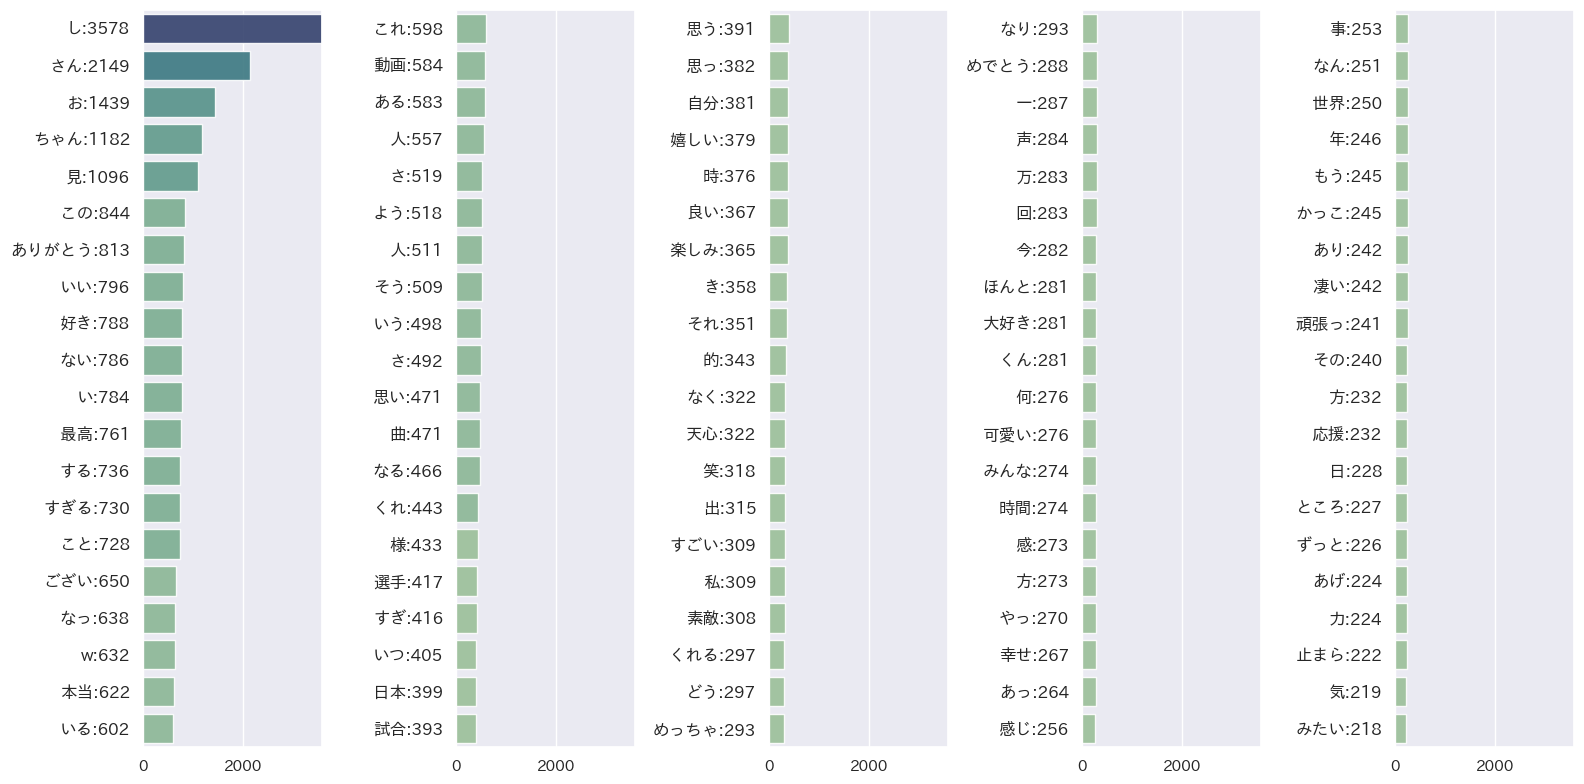

In [115]:
# Split DF into 5 equal sections
# And make a list of the start and end indices for each subsection
index_list = [[i[0], i[-1] + 1] for i in np.array_split(range(100), 5)]
max_val, min_val = freq_df['count'].max(), freq_df.iloc[99]['count']

fig, axs = plt.subplots(1, 5, figsize=(16, 8))
sns.set(font='IPAexGothic')

# Create a dictionary for color mappings
scaled_count = freq_df.iloc[0:99]['count'] // min_val
pal = list(sns.color_palette(palette='crest',
                             n_colors=scaled_count.max()).as_hex())
color_dict = dict(enumerate(pal, 1))

for col, i in enumerate(index_list):
    df = freq_df.iloc[i[0]:i[-1]]
    label = [f'{word}:{count}' for word, count in zip(df['word'], df['count'])]
    colors = [color_dict.get(val // min_val) for val in df['count']]
    x = list(df['count'])
    y = list(range(20))

    sns.barplot(x=x, y=y, alpha=0.9, orient='h',
               ax=axs[col], palette=colors)
    axs[col].set_xlim(0, max_val + 1)
    axs[col].set_yticklabels(label, fontsize=12)

plt.tight_layout()
plt.show()